In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict, deque

from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim

np.set_printoptions(suppress=True)

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load data

In [2]:
ml_ratings_df = pd.read_csv(os.path.join("data", "movielens_small", "ratings.csv")).rename(columns={'userId': 'user_id', 'movieId': 'item_id'})
ml_movies_df = pd.read_csv(os.path.join("data", "movielens_small", "movies.csv")).rename(columns={'movieId': 'item_id'})
ml_df = pd.merge(ml_ratings_df, ml_movies_df, on='item_id')

# Filter the data to reduce the number of movies
seed = 6789
rng = np.random.RandomState(seed=seed)
left_ids = rng.choice(ml_movies_df['item_id'], size=90, replace=False)
left_ids = list(set(left_ids).union(set([1, 318, 1193, 1208, 1214, 1721, 2959, 3578, 4306, 109487])))

ml_ratings_df = ml_ratings_df.loc[ml_ratings_df['item_id'].isin(left_ids)]
ml_movies_df = ml_movies_df.loc[ml_movies_df['item_id'].isin(left_ids)]
ml_df = ml_df.loc[ml_df['item_id'].isin(left_ids)]

display(HTML(ml_movies_df.head(10).to_html()))

print("Number of interactions left: {}".format(len(ml_ratings_df)))

,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
143,171,Jeffrey (1995),Comedy|Drama
194,228,Destiny Turns on the Radio (1995),Comedy
199,233,Exotica (1994),Drama
230,267,Major Payne (1995),Comedy
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
313,355,"Flintstones, The (1994)",Children|Comedy|Fantasy
379,435,Coneheads (1993),Comedy|Sci-Fi
419,481,Kalifornia (1993),Drama|Thriller
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller


Number of interactions left: 2761


## Shift item ids and user ids so that they are consecutive

In [3]:
interactions_df = ml_ratings_df.copy()

unique_item_ids = interactions_df['item_id'].unique()
item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
unique_user_ids = interactions_df['user_id'].unique()
user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

interactions_df['item_id'] = interactions_df['item_id'].map(item_id_mapping)
interactions_df['user_id'] = interactions_df['user_id'].map(user_id_mapping)

display(interactions_df.head(10))

,user_id,item_id,rating,timestamp
0,0,0,4.0,964982703
42,0,1,3.0,964984086
72,0,2,4.0,964983250
75,0,3,4.0,964981855
97,0,4,4.0,964980985
192,0,5,5.0,964983282
216,0,6,4.0,964981725
219,0,7,5.0,964980668
232,1,8,3.0,1445714835
235,1,7,4.0,1445714885


## Get the number of items and users

In [4]:
n_items = np.max(interactions_df['item_id']) + 1
n_users = np.max(interactions_df['user_id']) + 1

print("n_items={}\nn_users={}".format(n_items, n_users))

n_items=100
n_users=555


## Get the user-item interaction matrix

In [5]:
# mapping to int is necessary because of how iterrows works
r = np.zeros(shape=(n_users, n_items))
for idx, interaction in interactions_df.iterrows():
    r[int(interaction['user_id'])][int(interaction['item_id'])] = 1
    
print(r)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


## Generate negative interactions

In [6]:
n_neg_per_pos = 5
interactions_pos_neg_df = interactions_df[['user_id', 'item_id']].copy()

# Indicate positive interactions

interactions_pos_neg_df['interacted'] = 1

# Generate negative interactions

negative_interactions = []

i = 0
while i < n_neg_per_pos * len(interactions_df):
    sample_size = 1000
    user_ids = rng.choice(np.arange(n_users), size=sample_size)
    item_ids = rng.choice(np.arange(n_items), size=sample_size)

    j = 0
    while j < sample_size and i < n_neg_per_pos * len(interactions_df):
        if r[user_ids[j]][item_ids[j]] == 0:
            negative_interactions.append([user_ids[j], item_ids[j], 0])
            i += 1
        j += 1

interactions_pos_neg_df = pd.concat(
    [interactions_pos_neg_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
interactions_pos_neg_df = interactions_pos_neg_df.reset_index(drop=True)

**Task 1.** Code the GMFModel as described in the He et al., Neural Collaborative Filtering paper.

In [7]:
class GMFModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 1, bias=False)


    def forward(self, x):
        """
        :param torch.Tensor x: Tensor of size batch_size x 2. Every row contains two values - user id in the first column 
            and item id in the second column.
        """
        user_ids = x[:,0]
        item_ids = x[:,1]
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        x=self.fc(user_embedding * item_embedding)
        x = torch.sigmoid(x)
        return x

In [8]:
# Basic test of the model

net = GMFModel(
    n_items=n_items, 
    n_users=n_users, 
    embedding_dim=8, 
    seed=seed)

display(interactions_pos_neg_df[:10])
display(interactions_pos_neg_df[-10:])
print()
result = net(torch.from_numpy(interactions_pos_neg_df[:10][['user_id', 'item_id']].values).long())
print(result)
assert torch.allclose(result, torch.tensor([[0.5502], [0.8116], [0.3320], [0.6224], [0.9059], [0.7631], [0.3816], [0.8437], 
                                            [0.5892], [0.6404]]), atol=1e-04)
print()
result = net(torch.from_numpy(interactions_pos_neg_df[-10:][['user_id', 'item_id']].values).long())
print(result)
assert torch.allclose(result, torch.tensor([[0.3559], [0.5642], [0.3651], [0.4302], [0.4346], [0.3870], [0.5180], [0.4654], 
                                            [0.5181], [0.4620]]), atol=1e-04)

,user_id,item_id,interacted
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,1,8,1
9,1,7,1


,user_id,item_id,interacted
16556,349,12,0
16557,388,13,0
16558,416,69,0
16559,9,6,0
16560,342,96,0
16561,18,61,0
16562,254,72,0
16563,238,78,0
16564,551,55,0
16565,301,31,0



tensor([[0.5502],
        [0.8116],
        [0.3320],
        [0.6224],
        [0.9059],
        [0.7631],
        [0.3816],
        [0.8437],
        [0.5892],
        [0.6404]], grad_fn=<SigmoidBackward>)

tensor([[0.3559],
        [0.5642],
        [0.3651],
        [0.4302],
        [0.4346],
        [0.3870],
        [0.5180],
        [0.4654],
        [0.5181],
        [0.4620]], grad_fn=<SigmoidBackward>)


**Task 2.** Code the MLPModel as described in the He et al., Neural Collaborative Filtering paper. Use two hidden layers.

In [9]:
class MLPModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, hidden_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int hidden_dim: Dimension of the first hidden layer.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        dim = int(hidden_dim / 2)
        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, dim, bias=True)
        self.fc3 = nn.Linear(dim, 1, bias=False)


    def forward(self, x):
        """
        :param torch.Tensor x: Tensor of size batch_size x 2. Every row contains two values - user id in the first column 
            and item id in the second column.
        """
        user = x[:, 0]
        item = x[:, 1]

        x = torch.cat([self.user_embedding(user), self.item_embedding(item)], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))


In [10]:
# Basic test of the model

net = MLPModel(
    n_items=n_items, 
    n_users=n_users, 
    embedding_dim=8, 
    hidden_dim=16,
    seed=seed)

display(interactions_pos_neg_df[:10])
display(interactions_pos_neg_df[-10:])
print()
result = net(torch.from_numpy(interactions_pos_neg_df[:10][['user_id', 'item_id']].values).long())
print(result)
assert torch.allclose(result, torch.tensor([[0.5387], [0.5004], [0.4918], [0.4821], [0.5004], [0.4994], [0.5055], [0.5166],
                                            [0.4612], [0.4645]]), atol=1e-04)
print()
result = net(torch.from_numpy(interactions_pos_neg_df[-10:][['user_id', 'item_id']].values).long())
print(result)
assert torch.allclose(result, torch.tensor([[0.5154], [0.5140], [0.5110], [0.4910], [0.4899], [0.5082], [0.4688], [0.5164],
                                            [0.4983], [0.5035]]), atol=1e-04)

,user_id,item_id,interacted
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,1,8,1
9,1,7,1


,user_id,item_id,interacted
16556,349,12,0
16557,388,13,0
16558,416,69,0
16559,9,6,0
16560,342,96,0
16561,18,61,0
16562,254,72,0
16563,238,78,0
16564,551,55,0
16565,301,31,0



tensor([[0.5387],
        [0.5004],
        [0.4918],
        [0.4821],
        [0.5004],
        [0.4994],
        [0.5055],
        [0.5166],
        [0.4612],
        [0.4645]], grad_fn=<SigmoidBackward>)

tensor([[0.5154],
        [0.5140],
        [0.5110],
        [0.4910],
        [0.4899],
        [0.5082],
        [0.4688],
        [0.5164],
        [0.4983],
        [0.5035]], grad_fn=<SigmoidBackward>)


**Task 3.** Code the NeuMFModel as described in the He et al., Neural Collaborative Filtering paper. Use two hidden layers in the MLP part.

In [11]:
class NeuMFModel(nn.Module):
    def __init__(self, n_items, n_users, gmf_embedding_dim, mlp_embedding_dim, hidden_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int hidden_dim: Dimension of the first hidden layer of the MLP part of the network.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        dim = int(hidden_dim / 2)
        self.seed = torch.manual_seed(seed)
        self.gmf_user_embedding = nn.Embedding(n_users, gmf_embedding_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, gmf_embedding_dim)
        self.mlp_user_embedding = nn.Embedding(n_users, mlp_embedding_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, mlp_embedding_dim)
        self.mlp_fc1 = nn.Linear(2 * mlp_embedding_dim, hidden_dim, bias=True)
        self.mlp_fc2 = nn.Linear(hidden_dim, dim, bias=True)
        self.fc = nn.Linear(gmf_embedding_dim + dim, 1, bias=False)


    def forward(self, x):
        """
        :param torch.Tensor x: Tensor of size batch_size x 2. Every row contains two values - user id in the first column 
            and item id in the second column.
        """
        user = x[:, 0]
        item = x[:, 1]
        gmf_user_embedding = self.gmf_user_embedding(user)
        gmf_item_embedding = self.gmf_item_embedding(item)
        gmf_x = gmf_user_embedding * gmf_item_embedding
        mlp_user_embedding = self.mlp_user_embedding(user)
        mlp_item_embedding = self.mlp_item_embedding(item)
        mlp_x = torch.cat([self.mlp_user_embedding(user), self.mlp_item_embedding(item)], dim=1)
        mlp_x = torch.relu(self.mlp_fc1(mlp_x))
        mlp_x = torch.relu(self.mlp_fc2(mlp_x))
        mlp_x = torch.cat([gmf_x, mlp_x], dim=1)

        return torch.sigmoid(self.fc(mlp_x))

In [12]:
# Basic test of the model

net = NeuMFModel(
    n_items=n_items, 
    n_users=n_users, 
    gmf_embedding_dim=8, 
    mlp_embedding_dim=8, 
    hidden_dim=16,
    seed=seed)

display(interactions_pos_neg_df[:10])
display(interactions_pos_neg_df[-10:])
print()
result = net(torch.from_numpy(interactions_pos_neg_df[:10][['user_id', 'item_id']].values).long())
print(result)
assert torch.allclose(result, torch.tensor([[0.5841], [0.3518], [0.5470], [0.6893], [0.4029], [0.5030], [0.4145], [0.3592],
                                            [0.5345], [0.3968]]), atol=1e-04)
print()
result = net(torch.from_numpy(interactions_pos_neg_df[-10:][['user_id', 'item_id']].values).long())
print(result)
assert torch.allclose(result, torch.tensor([[0.4201], [0.5565], [0.6616], [0.3611], [0.6450], [0.4355], [0.5193], [0.4625],
                                            [0.5642], [0.6547]]), atol=1e-04)

,user_id,item_id,interacted
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,1,8,1
9,1,7,1


,user_id,item_id,interacted
16556,349,12,0
16557,388,13,0
16558,416,69,0
16559,9,6,0
16560,342,96,0
16561,18,61,0
16562,254,72,0
16563,238,78,0
16564,551,55,0
16565,301,31,0



tensor([[0.5841],
        [0.3518],
        [0.5470],
        [0.6893],
        [0.4029],
        [0.5030],
        [0.4145],
        [0.3592],
        [0.5345],
        [0.3968]], grad_fn=<SigmoidBackward>)

tensor([[0.4201],
        [0.5565],
        [0.6616],
        [0.3611],
        [0.6450],
        [0.4355],
        [0.5193],
        [0.4625],
        [0.5642],
        [0.6547]], grad_fn=<SigmoidBackward>)


**Task 4.** Code the train_ncf method which takes a neural collaborative filtering model and performs mini-batch gradient descent to train the model. The interface of the method should be as follows:

    train_ncf(net, interactions_df, n_epochs, batch_size, lr, weight_decay, seed)

where net is an initialized neural network which takes a batch of pairs (user_id, item_id) as input and returns a tensor of scores for every pair, interactions_df is the interactions DataFrame with the following columns user_id, item_id, interacted, n_epochs is the number of epochs (i.e. the number of times the network should be trained on the entire dataset), batch_size is the mini-batch size on which a single loss should be calculated and backpropagated, lr is the learning rate for SGD, weight_decay is the L2 penalty weight, seed is the seed for the random number generator.

In [13]:
def train_ncf(net, interactions_df, n_epochs, batch_size, lr, weight_decay, seed):
    """
    :param type net: Trained neural network which takes a batch of pairs (user_id, item_id) 
        as input and returns a tensor of scores for every pair.
    :param pd.DataFrame interactions_df: Interactions DataFrame with the following columns user_id, item_id, interacted.
    :param int n_epochs: Number of epochs.
    :param int batch_size: Batch size.
    :param float lr: Learning rate.
    :param float weight_decay: L2 penalty weight.
    :param int seed: Seed for the random number generator.
    """
    liveloss = PlotLosses()
    rng = np.random.RandomState(seed=seed)

    # Initialize the Adam optimizer

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    
    # Train the model 
    # Write an external loop over epochs and an internal loop over batches.
    # For every epoch first shuffle the ids of interactions_df using rng.permutation and then select
    # the elements of interactions_df through those shuffled ids.
    # Remember that the dataset size may be indivisible by batch_size.
    # Make sure to also use the last incomplete batch for training.
    # After generating model results clip them with clip(0.000001, 0.999999) to avoid the error of trying to
    # calculate log(0) in the loss function

    for epoch in range(n_epochs):
        epoch_total_loss = 0.0
        interactions_ids = rng.permutation(len(interactions_df))
        n_batches = int(np.ceil(len(interactions_df)/batch_size))
        for idx in range(n_batches):
            batch_ids = interactions_ids[(idx * batch_size):((idx+1) * batch_size)]
            batch = interactions_df.loc[batch_ids]
            batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long()
            y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float()
            y = net(batch_input).clip(0.000001, 0.999999)
            optimizer.zero_grad()
            loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
            loss.backward()
            optimizer.step()
            epoch_total_loss += loss.item()

        # Print epoch losses

        epoch_avg_loss = epoch_total_loss / len(interactions_ids)

        if epoch >= 0:
            # A bound on epoch prevents showing extremely high losses in the first epochs
            logs = {}
            logs['loss'] = epoch_avg_loss
            liveloss.update(logs)
            liveloss.send()

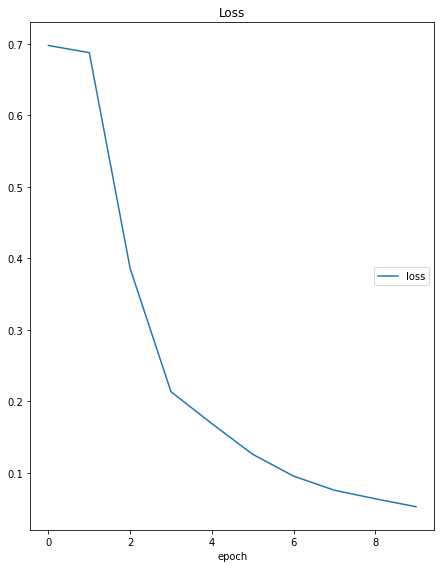

Loss
	loss             	 (min:    0.052, max:    0.698, cur:    0.052)


,user_id,item_id,interacted
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,1,8,1
9,1,7,1


,user_id,item_id,interacted
16556,349,12,0
16557,388,13,0
16558,416,69,0
16559,9,6,0
16560,342,96,0
16561,18,61,0
16562,254,72,0
16563,238,78,0
16564,551,55,0
16565,301,31,0



tensor([[0.9965],
        [1.0000],
        [0.9643],
        [1.0000],
        [0.8465],
        [0.9877],
        [0.9028],
        [0.9575],
        [0.9999],
        [0.9792]], grad_fn=<SigmoidBackward>)

tensor([[9.2855e-04],
        [1.2987e-04],
        [8.2114e-05],
        [3.9465e-03],
        [1.1282e-07],
        [1.3399e-02],
        [6.6296e-05],
        [2.0571e-02],
        [3.7681e-03],
        [2.4262e-04]], grad_fn=<SigmoidBackward>)


In [14]:
# Test the method

net = GMFModel(
    n_items=n_items, 
    n_users=n_users, 
    embedding_dim=8, 
    seed=seed)

train_ncf(net=net, interactions_df=interactions_pos_neg_df, n_epochs=10, batch_size=64, lr=0.01, weight_decay=0.001, seed=6789)

display(interactions_pos_neg_df[:10])
display(interactions_pos_neg_df[-10:])
print()
result = net(torch.from_numpy(interactions_pos_neg_df[:10][['user_id', 'item_id']].values).long())
print(result)
assert torch.allclose(result, torch.tensor([[0.9965], [1.0000], [0.9643], [1.0000], [0.8465], [0.9877], [0.9028], [0.9575],
                                            [0.9999], [0.9792]]), atol=1e-04)
print()
result = net(torch.from_numpy(interactions_pos_neg_df[-10:][['user_id', 'item_id']].values).long())
print(result)
assert torch.allclose(result, torch.tensor([[9.2855e-04], [1.2987e-04], [8.2114e-05], [3.9465e-03], [1.1282e-07], [1.3399e-02],
                                            [6.6296e-05], [2.0571e-02], [3.7681e-03], [2.4262e-04]]), atol=1e-04)

**Task 5.** Code the recommend method which takes user_id, interactions_df and a trained neural collaborative filtering model as input and returns the best recommendation (item_id) and its score for the given user based on scores calculated by the network for every pair user_id, item_id. Remember to map the user id with user_id_mapping at the beginning and item_id with item_id_reverse_mapping before returning item_id. Do not include films the user has already watched.

In [ ]:
def recommend(user_id, interactions_df, net):
    """
    :param int user_id: User id (as in the original dataset before the indices shift).
    :param pd.DataFrame interactions_df: Interactions DataFrame with the following columns user_id, item_id.
    :param type net: Trained neural network which takes a batch of pairs (user_id, item_id) 
        as input and returns a tensor of scores for every pair.
    """
    ########################
    # Write your code here #
    ########################



# Test

user_id = user_id_reverse_mapping[534]
item_id, score = recommend(user_id, interactions_df, net)
title = ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]

print("Best item id: {}".format(item_id))
print("Best item title: {}".format(title))
print("Best item score: {}".format(score))
assert item_id == 1500
assert np.abs(score - 0.9996901750564575) < 0.001

# Generalized Matrix Factorization recommender

In [ ]:
from livelossplot import PlotLosses

from recommenders.recommender import Recommender


class GMFRecommender(Recommender):
    """
    General Matrix Factorization recommender as described in:
    - He X., Liao L., Zhang H., Nie L., Hu X., Chua T., Neural Collaborative Filtering, WWW Conference, 2017
    """

    def __init__(self, seed=6789, n_neg_per_pos=5, print_type=None, **params):
        super().__init__()
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.interactions_df = None
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        self.r = None
        self.most_popular_items = None
        
        self.nn_model = None
        self.optimizer = None
        
        self.n_neg_per_pos = n_neg_per_pos
        if 'n_epochs' in params:  # number of epochs (each epoch goes through the entire training set)
            self.n_epochs = params['n_epochs']
        else:
            self.n_epochs = 10
        if 'lr' in params:  # learning rate
            self.lr = params['lr']
        else:
            self.lr = 0.01
        if 'weight_decay' in params:  # weight decay (L2 regularization)
            self.weight_decay = params['weight_decay']
        else:
            self.weight_decay = 0.001
        if 'embedding_dim' in params:
            self.embedding_dim = params['embedding_dim']
        else:
            self.embedding_dim = 4
        if 'batch_size' in params:
            self.batch_size = params['batch_size']
        else:
            self.batch_size = 64
        if 'device' in params:
            self.device = params['device']
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if 'should_recommend_already_bought' in params:
            self.should_recommend_already_bought = params['should_recommend_already_bought']
        else:
            self.should_recommend_already_bought = False
        
        if 'train' in params:
            self.train = params['train']
        else:
            self.train = False
        self.validation_set_size = 0.2
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        torch.manual_seed(seed)
        
        if 'should_save_model' in params:
            self.should_save_model = params['should_save_model']
        self.print_type = print_type

    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.

        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by
            user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined
            by item_id and the item feature columns.
        """

        del users_df, items_df

        # Shift item ids and user ids so that they are consecutive

        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

        interactions_df = interactions_df.copy()
        interactions_df['item_id'] = interactions_df['item_id'].map(self.item_id_mapping)
        interactions_df['user_id'] = interactions_df['user_id'].map(self.user_id_mapping)

        # Get the number of items and users

        self.interactions_df = interactions_df.copy()
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1

        # Get the user-item interaction matrix (mapping to int is necessary because of how iterrows works)
        r = np.zeros(shape=(n_users, n_items))
        for idx, interaction in interactions_df.iterrows():
            r[int(interaction['user_id'])][int(interaction['item_id'])] = 1

        self.r = r
        
        # Indicate positive interactions
        
        interactions_df.loc[:, 'interacted'] = 1

        # Generate negative interactions
        negative_interactions = []

        i = 0
        while i < self.n_neg_per_pos * len(interactions_df):
            sample_size = 1000
            user_ids = self.rng.choice(np.arange(n_users), size=sample_size)
            item_ids = self.rng.choice(np.arange(n_items), size=sample_size)

            j = 0
            while j < sample_size and i < self.n_neg_per_pos * len(interactions_df):
                if r[user_ids[j]][item_ids[j]] == 0:
                    negative_interactions.append([user_ids[j], item_ids[j], 0])
                    i += 1
                j += 1
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions_df = interactions_df.reset_index(drop=True)
        
        # Initialize losses and loss visualization
        
        if self.print_type is not None and self.print_type == 'live':
            liveloss = PlotLosses()

        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0
        
        # Initialize the network
        
        self.nn_model = GMFModel(n_items, n_users, self.embedding_dim, self.seed)
        self.nn_model.train()
        self.nn_model.to(self.device)
        self.optimizer = optim.Adam(self.nn_model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        # Split the data
        
        if self.train:
            interaction_ids = self.rng.permutation(len(interactions_df))
            train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
            training_ids = interaction_ids[:train_validation_slice_idx]
            validation_ids = interaction_ids[train_validation_slice_idx:]
        else:
            interaction_ids = self.rng.permutation(len(interactions_df))
            training_ids = interaction_ids
            validation_ids = []
        
        # Train the model
        
        for epoch in range(self.n_epochs):
            if self.print_type is not None and self.print_type == 'live':
                logs = {}
                
            # Train
            
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))
            
            for batch_idx in range(n_batches):
                
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                
                batch = interactions_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                
                # Create responses

                y = self.nn_model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate

                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                
                if self.print_type is not None and self.print_type == 'text':
                    print("\rEpoch: {}\tBatch: {}\tLast epoch - avg training loss: {:.2f} avg validation loss: {:.2f} loss: {}".format(
                        epoch, batch_idx, last_training_total_loss, last_validation_total_loss, loss), end="")
                
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
            # Validate
            
            if self.train:

                validation_total_loss = 0.0

                batch = interactions_df.loc[validation_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)

                # Create responses

                y = self.nn_model(batch_input).clip(0.000001, 0.999999)

                # Calculate validation loss

                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                validation_total_loss += loss.item()
                
            # Save and print epoch losses
            
            training_last_avg_loss = training_total_loss / len(training_ids)
            
            if self.train:
                validation_last_avg_loss = validation_total_loss / len(validation_ids)

            if self.print_type is not None and self.print_type == 'live' and epoch >= 0:
                # A bound on epoch prevents showing extremely high losses in the first epochs
                logs['loss'] = training_last_avg_loss
                if self.train:
                    logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()

        # Find the most popular items for the cold start problem

        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index

    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns
        top n_recommendations for each user.

        :param pd.DataFrame users_df: DataFrame with users and their features for which
            recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations
            for each user.
        :rtype: pd.DataFrame
        """

        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]

        # Handle users not in the training data

        # Map item ids

        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)

        # Generate recommendations

        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']

            if user_id in self.user_id_mapping:
                
                mapped_user_id = self.user_id_mapping[user_id]
                
                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k
                
                net_input = torch.tensor(list(zip([mapped_user_id]*len(ids_list), ids_list))).to(self.device)
                
                scores = self.nn_model(net_input).flatten().detach().cpu().numpy()
                
                # Choose n recommendations based on highest scores
                if not self.should_recommend_already_bought:
                    x_list = self.interactions_df.loc[
                        self.interactions_df['user_id'] == mapped_user_id]['item_id'].tolist()
                    scores[id_to_pos[x_list]] = -np.inf

                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            else:  # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df
    
    def get_user_repr(self, user_id):
        mapped_user_id = self.user_id_mapping[user_id]
        return self.nn_model.user_embedding(torch.tensor(mapped_user_id).to(self.device)).detach().cpu().numpy()
    
    def get_item_repr(self, item_id):
        mapped_item_id = self.item_id_mapping[item_id]
        return self.nn_model.item_embedding(torch.tensor(mapped_item_id).to(self.device)).detach().cpu().numpy()

## Quick test of the recommender (training)

In [ ]:
gmf_recommender = GMFRecommender(print_type='live', n_neg_per_pos=10, batch_size=16, 
                                 embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=30, seed=1, train=True)
gmf_recommender.fit(ml_ratings_df, None, ml_movies_df)

## Quick test of the recommender (recommending)

In [ ]:
recommendations = gmf_recommender.recommend(pd.DataFrame([[1], [4], [6]], columns=['user_id']), ml_movies_df, 10)

recommendations = pd.merge(recommendations, ml_movies_df, on='item_id', how='left')
print("Recommendations")
display(HTML(recommendations.to_html()))

## User and item representations

In [ ]:
user_id = 1
user_repr = gmf_recommender.get_user_repr(user_id=user_id)
print("User id={}".format(user_id))
print(user_repr)
print()

print("User watched")
print(ml_df.loc[ml_df['user_id'] == user_id, 'title'].tolist())
print()

print('User history item representations')
for item_id in ml_df.loc[ml_df['user_id'] == user_id, 'item_id'].tolist():
    item_repr = gmf_recommender.get_item_repr(item_id=item_id)
    print("Item id = {}\titem title = {}".format(
        item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
    print(item_repr)
    scalar_product = np.dot(user_repr, item_repr)
    print("Scalar product={:.6f}".format(scalar_product))
    score = gmf_recommender.nn_model(
        torch.tensor([[gmf_recommender.user_id_mapping[user_id], 
                       gmf_recommender.item_id_mapping[item_id]]]).to(gmf_recommender.device)).flatten().detach().cpu().item()
    print("Score={:.6f}".format(score))
    print()

print("===============")
    
item_id = 145
item_repr = gmf_recommender.get_item_repr(item_id=item_id)
print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
print(item_repr)
score = np.dot(user_repr, item_repr)
print("Scalar product={:.6f}".format(score))
score = gmf_recommender.nn_model(
    torch.tensor([[gmf_recommender.user_id_mapping[user_id], 
                   gmf_recommender.item_id_mapping[item_id]]]).to(gmf_recommender.device)).flatten().detach().cpu().item()
print("Score={:.6f}".format(score))
print()

item_id = 171
item_repr = gmf_recommender.get_item_repr(item_id=item_id)
print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
print(item_repr)
score = np.dot(user_repr, item_repr)
print("Scalar product={:.6f}".format(score))
score = gmf_recommender.nn_model(
    torch.tensor([[gmf_recommender.user_id_mapping[user_id], 
                   gmf_recommender.item_id_mapping[item_id]]]).to(gmf_recommender.device)).flatten().detach().cpu().item()
print("Score={:.6f}".format(score))

# Training-test split evaluation

In [ ]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

In [ ]:
gmf_recommender = GMFRecommender(n_neg_per_pos=10, batch_size=16, 
                                 embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=25)

gmf_tts_results = [['GMFRecommender'] + list(evaluate_train_test_split_implicit(
    gmf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

gmf_tts_results = pd.DataFrame(
    gmf_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_tts_results.to_html()))

In [ ]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(n_epochs=150)

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [ ]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

In [ ]:
from recommenders.tfidf_recommender import TFIDFRecommender

tfidf_recommender = TFIDFRecommender()

tfidf_tts_results = [['TFIDFRecommender'] + list(evaluate_train_test_split_implicit(
    tfidf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

tfidf_tts_results = pd.DataFrame(
    tfidf_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(tfidf_tts_results.to_html()))

In [ ]:
tts_results = pd.concat([gmf_tts_results, netflix_tts_results, amazon_tts_results, tfidf_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

# Leave-one-out evaluation

In [ ]:
from evaluation_and_testing.testing import evaluate_leave_one_out_implicit

In [ ]:
gmf_recommender = GMFRecommender(n_neg_per_pos=10, batch_size=16, 
                                 embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=25)

gmf_loo_results = [['GMFRecommender'] + list(evaluate_leave_one_out_implicit(
    gmf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

gmf_loo_results = pd.DataFrame(
    gmf_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_loo_results.to_html()))

In [ ]:
netflix_recommender = NetflixRecommender(n_epochs=150)

netflix_loo_results = [['NetflixRecommender'] + list(evaluate_leave_one_out_implicit(
    netflix_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

netflix_loo_results = pd.DataFrame(
    netflix_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_loo_results.to_html()))

In [ ]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_loo_results = [['AmazonRecommender'] + list(evaluate_leave_one_out_implicit(
    amazon_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

amazon_loo_results = pd.DataFrame(
    amazon_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_loo_results.to_html()))

In [ ]:
tfidf_recommender = TFIDFRecommender()

tfidf_loo_results = [['TFIDFRecommender'] + list(evaluate_leave_one_out_implicit(
    tfidf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

tfidf_loo_results = pd.DataFrame(
    tfidf_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(tfidf_loo_results.to_html()))

In [ ]:
loo_results = pd.concat([gmf_loo_results, netflix_loo_results, amazon_loo_results, tfidf_loo_results]).reset_index(drop=True)
display(HTML(loo_results.to_html()))